<a href="https://colab.research.google.com/github/JoaoGranja/Jane-Street-Market-NN/blob/main/Jane_Street_Market_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download Dataset and install needed libraries

In [1]:
import os

In [2]:
#from google.colab import files
#uploaded = files.upload()

#Package Installation
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

from google.colab import drive
drive.mount('/content/drive')

!mkdir ~/.kaggle
!cp drive/MyDrive/colab/kaggle.json ~/.kaggle/kaggle.json
#!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

Found existing installation: kaggle 1.5.6
Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
  Using cached kaggle-1.5.6-py3-none-any.whl
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
#! kaggle competitions list

In [4]:
!kaggle competitions download -c 'jane-street-market-prediction'

100% 2.63G/2.63G [00:40<00:00, 47.0MB/s]
100% 2.63G/2.63G [00:40<00:00, 70.0MB/s]


In [5]:
! mkdir model

#! kaggle datasets download -d 'granja/restnet50modelstatewithyaw'
#! unzip restnet50modelstatewithyaw.zip -d model

! unzip jane-street-market-prediction.zip
%rm -r jane-street-market-prediction.zip

mkdir: cannot create directory ‘model’: File exists
Archive:  jane-street-market-prediction.zip
replace example_sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [1]:
# Imports
import time, os, random
from typing import Dict
import gc
from google.colab import files
import numpy as np
import pandas as pd
from tempfile import gettempdir
import matplotlib.pyplot as plt
from tqdm import tqdm
from prettytable import PrettyTable
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch import nn, optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.models.resnet import resnet50, resnet34
from torchvision import transforms
from torch.utils.data import TensorDataset, Dataset
#from efficientnet_pytorch import EfficientNet

import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler, minmax_scale
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.impute import SimpleImputer


# **Configuration**



In [24]:
dataset_path='/content/train.csv'

cfg = {
    'model_params': {
        'model_architecture': 'nn',
        'model_name': "nn_output",
        'n_hidden': 512,
        'n_layers': 2,
        'lr': 1e-3,
        'weight_path': 'drive/MyDrive/colab/nn_model_state_9999.pth',
        'train': True,
        'validate': False
    },

    'train_params': {
        'max_num_steps': 10000,
        'checkpoint_every_n_steps': 2000,
        'batch_size': 4096,
        'valid_split': 0.1,
    }
}



In [3]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(seed=42)

# **Loading the cleaning data**


In [4]:
# Import dataset as train
train = pd.read_csv(dataset_path) #, nrows=200000)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2390491 entries, 0 to 2390490
Columns: 138 entries, date to ts_id
dtypes: float64(135), int64(3)
memory usage: 2.5 GB


In [5]:
#train.describe()

In [6]:
#train['date'].value_counts()

In [7]:
#train['weight'].hist()
#plt.show()

In [8]:

features = [col for col in list(train.columns) if 'feature' in col]
train = train.query('weight > 0').reset_index(drop = True)
train_mean = train[features].mean()
train[features] = train[features].fillna(method = 'ffill').fillna(train_mean)
train['action'] = (train['resp'] > 0).astype('int')

**Exploratory Data Analysis**

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


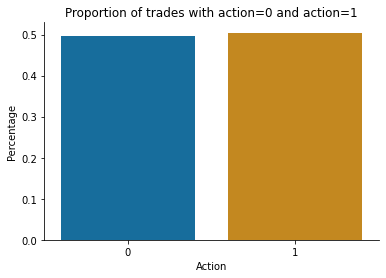

In [9]:
# First, we want to check if the target class is balanced or unbalanced in the training data
sns.set_palette("colorblind")
ax = sns.barplot(train['action'].value_counts().index, train['action'].value_counts()/len(train))
ax.set_title("Proportion of trades with action=0 and action=1")
ax.set_ylabel("Percentage")
ax.set_xlabel("Action")
sns.despine();
# Target class is fairly balanced with almost 50% of trades corresponding to each action

**Features Correlation**

We are going to investigate the correlation between all fetures of the dataset. In case strong correlation exists, we can apply a Principle Component Analysis to reduze the dimensionality of this dataset.

In [10]:
heatmap = False
if heatmap:
  # Set up the matplotlib figure
  f, ax = plt.subplots(figsize=(12, 10))

  # Compute the correlation matrix
  corr = train_features.corr()

  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corr, vmin=-1, vmax=1, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})

**Feature Preprocessing:** imputation, scaling, and constructing new features

In [12]:
#Scaling
scaler = StandardScaler()
scaler.fit(train[features])
X_train_norm = pd.DataFrame(scaler.transform(train[features]))


In [13]:
#constructing new features

**Feature selection:** dimensionality reduction, to select the best subset of our current set of features

In [14]:
PCA = False
if PCA:
  pca = PCA()
  comp = pca.fit(X_train_norm)

  # We plot a graph to show how the explained variation in the 129 features varies with the number of principal components
  plt.plot(np.cumsum(comp.explained_variance_ratio_))
  plt.grid()
  plt.xlabel('Number of Principal Components')
  plt.ylabel('Explained Variance')
  sns.despine();

  # The first 15 principal components explains about 80% of the variation
  # The first 40 principal components explains about 95% of the variation

In [15]:
if PCA:
  # Using the first 40 principal components, we apply the PCA mapping on both the training and test set
  pca = PCA(n_components=40).fit(X_train_norm)
  X_train_transform = pca.transform(X_train_norm)

In [16]:
class data(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_norm, train['action'], test_size=cfg["train_params"]["valid_split"], random_state=42)

torch_train_target = torch.tensor(y_train.values.astype(np.float32))
torch_train_features = torch.tensor(X_train.values.astype(np.float32)) 
  
torch_train_data = data(torch_train_features, torch_train_target)
train_dataloader = DataLoader(dataset = torch_train_data, batch_size = cfg["train_params"]["batch_size"], shuffle = True)

del X_train, y_train, train 

print(len(train_dataloader))

torch_valid_target = torch.tensor(y_valid.values.astype(np.float32))
torch_valid_features = torch.tensor(X_valid.values.astype(np.float32)) 
  
torch_valid_data = data(torch_valid_features, torch_valid_target)
valid_dataloader = DataLoader(dataset = torch_valid_data, batch_size = cfg["train_params"]["batch_size"], shuffle = True)

print(len(valid_dataloader))

del y_valid,  X_valid

436
49


In [18]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

**Model Selection:** evaluating many machine learning models


In [19]:
# define the CNN architecture
class JSMCNN(nn.Module):
    def __init__(self):
        super(JSMCNN, self).__init__()
        self.fc1 = nn.Linear(130, 1000)
        self.batchnorm1 = nn.BatchNorm1d(1000)
        self.fc2 = nn.Linear(1000, 500)
        self.batchnorm2 = nn.BatchNorm1d(500)
        self.fc3 = nn.Linear(500, 100)
        self.batchnorm3 = nn.BatchNorm1d(100)
        self.fc_out = nn.Linear(100, 1)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.batchnorm1(x)
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.batchnorm3(x)
        x = self.dropout(x)
        x = self.fc_out(x)
        return x
    

In [20]:
class JSMRNN(nn.Module):
    
    def __init__(self, features_len, n_hidden=256, n_layers=2, drop_prob=0.5):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        
        ## LSTM definition
        self.lstm = nn.LSTM(features_len, n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        ## Dropout layer definition 
        self.dropout = nn.Dropout(drop_prob)
        
        ## Final, fully-connected output layer definition
        self.fc = nn.Linear(n_hidden, 1)
      
    
    def forward(self, x, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
                
        ## Get the outputs and the new hidden state from the lstm
        r_output, hidden = self.lstm(x, hidden)
        
        ## Pass through a dropout layer
        out = self.dropout(r_output)
        
        # Stack up LSTM outputs using view
        # you may need to use contiguous to reshape the output
        out = out.contiguous().view(-1, self.n_hidden)
        
        ## Put x through the fully-connected layer
        out = F.sigmoid(self.fc(out))
        
        # return the final output and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (torch.cuda.is_available()):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden   

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
#Instantiate model

#--model = JSMRNN(1, cfg["model_params"]["n_hidden"], cfg["model_params"]["n_layers"]).to(device)
model = JSMCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=cfg["model_params"]["lr"]) 

# load weight if there is a pretrained model
weight_path = cfg["model_params"]["weight_path"]
if weight_path != '':
  model_state = torch.load(weight_path, map_location=device)
  model.load_state_dict(model_state['state_dict'])
  optimizer.load_state_dict(model_state['optimizer'])
  iteration = model_state['iteration']
else:
  iteration = 0
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
#--scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)



In [26]:
if cfg["model_params"]["train"]:
    progress_bar = tqdm( range(iteration, iteration+cfg["train_params"]["max_num_steps"]))
    losses_train = []
    acc_train = []
    iterations = []
    metrics = []
    times = []
    model_name = cfg["model_params"]["model_name"]
    start = time.time()

    #--h = model.init_hidden(cfg["train_params"]["batch_size"])
    tr_it = iter(train_dataloader)
    epoch = 0
    for i in progress_bar:
        try:
            x_data, y_data = next(tr_it)
        except StopIteration:
            epoch += 1
            #print(f"epoch: {epoch}")
            tr_it = iter(train_dataloader)
            x_data, y_data = next(tr_it)
        
        #--if x_data.shape[0] != cfg["train_params"]["batch_size"]:
        #--  print("break")
        #--  break

        model.train()
        torch.set_grad_enabled(True)

        #Move data to device
        #--inputs = x_data.to(device).unsqueeze(-1)
        inputs = x_data.to(device)
        targets = y_data.to(device)
        
        #Forward model
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        #--h = tuple([each.data for each in h])
        
        #--model.zero_grad()

        # get the output from the model
        #output, h = model(inputs, h)
        output = model(inputs).view(targets.shape)
  
        loss = criterion(output, targets)
        acc = binary_acc(output, targets)
        
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        #n.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # step the scheduler
        #--scheduler.step()

        losses_train.append(loss.item())
        acc_train.append(acc.item())

        progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)} \
        | Acc: {acc.item()} Acc(avg): {np.mean(acc_train)}")

        if ((i != 0) and (i % cfg['train_params']['checkpoint_every_n_steps'] == 0)):
          state = {
                  'iteration': i + 1,
                  'state_dict': model.state_dict(),
                  'optimizer': optimizer.state_dict(),
                  #'scheduler': scheduler,
                }  
          #torch.save(state, f'/content/drive/My Drive/colab/{cfg["model_params"]["model_architecture"]}_model_state_{i}.pth')  
          iterations.append(i)
          metrics.append(np.mean(losses_train))
          times.append((time.time()-start)/60)

          losses_valid = []
          acc_valid = []

          for x_data, y_data in  iter(valid_dataloader):
            model.eval()
            with torch.no_grad():
              inputs = x_data.to(device)
              targets = y_data.to(device)

              output = model(inputs).view(targets.shape)
              loss = criterion(output, targets)
              acc = binary_acc(output, targets)

              losses_valid.append(loss.item())
              acc_valid.append(acc.item())
          print(f"\n\n valid loss(avg): {np.mean(losses_valid)} | valid Acc(avg): {np.mean(acc_valid)}\n")  
    results = pd.DataFrame({"iterations": iterations, 'metrics (avg)': metrics, 'elapsed time (min)': times})
    results.to_csv(f'{model_name}_{cfg["train_params"]["max_num_steps"]}.csv', index=False)
    print(f"Total training time is {(time.time()-start)/60} mins")
    print(results.head())
    state = {
                  'iteration': i + 1,
                  'state_dict': model.state_dict(),
                  'optimizer': optimizer.state_dict(),
                  #'scheduler': scheduler,
                }  
    torch.save(state, f'/content/drive/My Drive/colab/{cfg["model_params"]["model_architecture"]}_model_state_{i}.pth')  


loss: 0.6609429121017456 loss(avg): 0.6612303058306376         | Acc: 57.0 Acc(avg): 57.0:   0%|          | 3/10000 [00:02<5:02:16,  1.81s/it]



 valid loss(avg): 0.6602828368848684 | valid Acc(avg): 56.93877551020408



loss: 0.6537613868713379 loss(avg): 0.6597386248636651         | Acc: 58.0 Acc(avg): 57.166250624063906:  20%|██        | 2003/10000 [02:21<42:19,  3.15it/s]



 valid loss(avg): 0.6562619233617977 | valid Acc(avg): 57.38775510204081



loss: 0.6550287008285522 loss(avg): 0.6576679552440996         | Acc: 59.0 Acc(avg): 57.41508491508492:  40%|████      | 4003/10000 [04:38<30:54,  3.23it/s]



 valid loss(avg): 0.6525517166877279 | valid Acc(avg): 57.816326530612244



loss: 0.6516958475112915 loss(avg): 0.6557783198646511         | Acc: 59.0 Acc(avg): 57.63607594936709:  60%|██████    | 6003/10000 [06:54<20:29,  3.25it/s]



 valid loss(avg): 0.6487411357918564 | valid Acc(avg): 58.0



loss: 0.6401795148849487 loss(avg): 0.654041764111831         | Acc: 58.0 Acc(avg): 57.8452023988006:  80%|████████  | 8003/10000 [09:11<10:12,  3.26it/s] 



 valid loss(avg): 0.6467127812152006 | valid Acc(avg): 58.42857142857143



loss: 0.6501681804656982 loss(avg): 0.6524599515080451         | Acc: 59.0 Acc(avg): 58.0275: 100%|██████████| 10000/10000 [11:25<00:00, 14.58it/s]


Total training time is 11.428395140171052 mins
   iterations  metrics (avg)  elapsed time (min)
0       10000       0.660205            0.003929
1       12000       0.659743            2.320475
2       14000       0.657671            4.597363
3       16000       0.655782            6.873300
4       18000       0.654046            9.154548


**Hyperparameter tuning:** finding the optimal model settings: training a number of models with different hyperparameters to find the best performer

# **Validation**

In [ ]:
#Example Test Prediction Analysis
example_test = pd.read_csv('/content/example_test.csv')
example_test = example_test.query('weight > 0').reset_index(drop = True)
example_test[features] = example_test[features].fillna(method = 'ffill').fillna(method = 'bfill').fillna(0)

test_features = torch.tensor(example_test[features].values.astype(np.float32)).to(device)

model.eval()
with torch.no_grad():
  y_test_pred = model(test_features)
  y_test_pred = torch.sigmoid(y_test_pred)
  y_pred_tag = torch.round(y_test_pred)
  y_pred_tag = y_test_pred.cpu().numpy()

print(y_pred_tag.min())
print(y_pred_tag.max())
print(y_pred_tag.mean())
print(y_pred_tag.std())

plt.hist(y_pred_tag, bins = 100)
plt.show()

In [ ]:
# We impute the missing values with the medians
def fillna_npwhere(array, values):
    if np.isnan(array.sum()):
        array = np.where(np.isnan(array), values, array)
    return array

import janestreet
env = janestreet.make_env() # initialize the environment
iter_test = env.iter_test() # an iterator which loops over the test set

for (test_df, sample_prediction_df) in iter_test:
    wt = test_df.iloc[0].weight
    if(wt == 0):
        sample_prediction_df.action = 0 
    else:
        sample_prediction_df.action = np.where(clf.predict(xgb.DMatrix(pca.transform(scaler.transform(fillna_npwhere(test_df[features].values,train_median[features].values)))))>=0.5,1,0).astype(int)
    env.predict(sample_prediction_df)


In [ ]:
print(pred_path)